In [1]:
import math
import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt
import openpyxl
import cmath
import graphviz
from array import array

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler

In [4]:
# Save an IBM Quantum account and set it as your default account.
API_Token = '13d9540e280b61b7a4254fcdb05516180957df07523dfef1924f7d9363699a51826b42e7a063b3fb685f295f6d27f8ff61810a97f503a704c07bc959d6cc6e3f'
QiskitRuntimeService.save_account(
    channel = "ibm_quantum",
    
    instance ="ibm-q-hub-ntu/ntu-internal/default",
    token = API_Token,
    set_as_default = True,
    # Use `overwrite=True` if you're updating your token.
    overwrite = True,
)

# Load saved credentials
service = QiskitRuntimeService()

#For real Device
#backend = service.least_busy(operational=True, simulator=False)
backend_nazca = service.backend("ibm_kyiv")
noise_model = NoiseModel.from_backend(backend_nazca)

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

#For FakeSimulator
#backend = FakeManilaV2()

# Get coupling map from backend
coupling_map = [[0, 1], [1, 2], [3, 2], [3, 4]]

#For Aer
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
#backend = AerSimulator()
#backend = AerSimulator.from_backend(backend_nazca)

backendqubitNum = backend.num_qubits

In [5]:
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg = QuantumRegister(2, 'q')
creg = ClassicalRegister(2, 'c')
q0_init = {}
q1_init = {}

for i in range (2):
    #rho0 state |0>
    InitCirZero = QuantumCircuit(qreg, creg)
    #rho1 state |1>
    InitCirOne = QuantumCircuit(qreg, creg)
    InitCirOne.x(i)
    #rho2 state |0>+|1>
    InitCirPlus = QuantumCircuit(qreg, creg)
    InitCirPlus.h(i)
    #rho3 state |0>+i|1>
    InitCirRight = QuantumCircuit(qreg, creg)
    InitCirRight.h(i)
    InitCirRight.s(i)
    
    if i == 0:
        q0_init = {'q0zero':InitCirZero, 'q0one':InitCirOne, 'q0plus':InitCirPlus, 'q0right':InitCirRight}
    else:
        q1_init = {'q1zero':InitCirZero, 'q1one':InitCirOne, 'q1plus':InitCirPlus, 'q1right':InitCirRight}

# Store the initial circuits in a dictionary
InitialState = {}
for q0, q0state in q0_init.items():
    for q1, q1state in q1_init.items():
        initcomb = q.circuit.QuantumCircuit.compose(q0state, q1state)
        InitialState.update({f'{q0}_{q1}':initcomb})

In [6]:
#Build Three measurement X, Y, Z
q0_meas = {}
q1_meas = {}

for i in range (2):
    #I-measurement
    MeasCirI = QuantumCircuit(qreg, creg)
    #X-measurement
    MeasCirX = QuantumCircuit(qreg, creg)
    MeasCirX.h(i)
    MeasCirX.measure(i, i)
    #Y-measurement
    MeasCirY = QuantumCircuit(qreg, creg)
    MeasCirY.sdg(i)
    MeasCirY.h(i)
    MeasCirY.measure(i, i)
    #Z-measurement
    MeasCirZ = QuantumCircuit(qreg, creg)
    MeasCirZ.measure(i, i)
    
    if i == 0:
        q0_meas = {'q0Imeas':MeasCirI, 'q0Xmeas':MeasCirX, 'q0Ymeas':MeasCirY, 'q0Zmeas':MeasCirZ}
    else:
        q1_meas = {'q1Imeas':MeasCirI, 'q1Xmeas':MeasCirX, 'q1Ymeas':MeasCirY, 'q1Zmeas':MeasCirZ}
    
# Store the measurement circuits in a dictionary
Measurement = {}
for q0, q0meas in q0_meas.items():
    for q1, q1meas in q1_meas.items():
        meascomb = q.circuit.QuantumCircuit.compose(q0meas, q1meas)
        Measurement.update({f'{q0}_{q1}':meascomb})

In [7]:
#Build each set of circuits with four kinds of Initialstates and four kinds of measurements
Circuit = {}
for MeasName, Measure in Measurement.items():
    for InitName, Initial in InitialState.items():
        circuit = q.circuit.QuantumCircuit.compose(Initial, Measure)
        Circuit.update({f'{InitName}_{MeasName}':circuit})

In [8]:
len(Circuit)

256

In [35]:
#print(Circuit.keys())

In [15]:
shots = 1000
sampler = Sampler(mode=backend)

job = {}
for Name, Cir in Circuit.items():
    CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
    job.update({Name:sampler.run([CirTran], shots=shots)})

In [16]:
result_origin = []
for index, job_name in job.items():
    res = job_name.result()
    result_origin.append(res[0].data.c.get_counts())
result_origin

[{'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 1000},
 {'00': 493, '10': 507},
 {'10': 490, '00': 510},
 {'00': 995, '10': 5},
 {'00': 508, '10': 492},
 {'10': 509, '00': 491},
 {'00': 496, '10': 504},
 {'00': 996, '10': 4},
 {'00': 521, '10': 479},
 {'00': 510, '10': 490},
 {'10': 499, '00': 501},
 {'00': 997, '10': 3},
 {'00': 517, '10': 483},
 {'10': 493, '00': 507},
 {'10': 498, '00': 502},
 {'00': 995, '10': 5},
 {'00': 493, '10': 507},
 {'00': 499, '10': 501},
 {'00': 480, '10': 520},
 {'00': 514, '10': 486},
 {'00': 998, '10': 2},
 {'10': 499, '00': 501},
 {'00': 501, '10': 499},
 {'00': 507, '10': 493},
 {'00': 997, '10': 3},
 {'00': 495, '10': 505},
 {'00': 546, '10': 454},
 {'10': 503, '00': 497},
 {'00': 997, '10': 3},
 {'10': 499, '00': 501},
 {'00': 518, '10': 482},
 {'00': 511, '10': 489},

In [17]:
# Required keys for each dictionary
required_keys = ['00', '01', '10', '11']

# Function to fill missing keys with 0
def fill_missing_keys(dicts, keys):
    return [{k: d.get(k, 0) for k in keys} for d in dicts]

# Fill missing keys in the input data
result = fill_missing_keys(result_origin, required_keys)

In [33]:
#Create GramMatrix g
g = np.ones((16,16))
for i in range (len(result)):
    row = int(i/16)
    column = i%16
    if i < 16:
        g[row][column] = (result[i]['00'] + result[i]['10'] + result[i]['01'] + result[i]['11'])/shots
    elif i%16 == 0 and i/16 < 4:
        g[row][column] = (result[i]['00'] - result[i]['10'] + result[i]['01'] - result[i]['11'])/shots
    elif i%64 == 0:
        g[row][column] = (result[i]['00'] + result[i]['10'] - result[i]['01'] - result[i]['11'])/shots
    else:
        g[row][column] = (result[i]['00'] - result[i]['10'] - result[i]['01'] + result[i]['11'])/shots

In [37]:
#Create State Preparation Matrix A
A_single = np.array([[1, 1, 1, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [1,-1, 0, 0]])
A = np.kron(A_single, A_single)
#print(A)

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
#print(A_inv)
B = np.matmul(g, A_inv)
B_inv = inv(B)
# print(B_inv)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])
a = {'i':a_i, 'x':a_x, 'y':a_y, 'z':a_z}
aa = {}
qq = {}
for f, first in a.items():
    for s, second in a.items():
        a_mix = np.kron(first, second)
        aa.update({f'a_{f}{s}':a_mix})
        q_mix = np.matmul(a_mix, B_inv)
        qq.update({f'q_{f}{s}':q_mix})
        
        print(f'a_{f}{s}:', a_mix)
        print(f'q_{f}{s}:', q_mix)
        print('\n')

a_ii: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
q_ii: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


a_ix: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
q_ix: [[ 0.00487587  1.00674324 -0.03649342  0.01088808 -0.01282342  0.00902019
   0.00984712 -0.0227975  -0.0119846   0.00757366  0.05698865 -0.01616169
  -0.01001522  0.01171195  0.02135791  0.00584359]]


a_iy: [[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
q_iy: [[ 0.00766362 -0.02724322  0.99658358 -0.00713188 -0.04725154  0.07939046
   0.05345937  0.06030288 -0.0260148   0.02108931  0.03004108  0.02947764
   0.00910761 -0.01441957 -0.01217769 -0.01437768]]


a_iz: [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]
q_iz: [[ 8.59636537e-04 -1.40037366e-03  5.00756970e-02  1.00725480e+00
   4.28464939e-03 -2.78685612e-03 -4.75183682e-03  4.14704617e-03
   2.75883933e-03 -3.27143440e-02 -5.91524099e-02  2.92575151e-03
   7.82370212e-04  3.11720211e-02  4.01019764e-03  1.10858103e-03]]


a_xi: [[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]
q_xi: [[-0.00884126 -0.01064738 -0.01059

In [68]:
q_reg = QuantumRegister(2, 'q')
c_reg = ClassicalRegister(2, 'c')

testCir = QuantumCircuit(q_reg, c_reg)
testCir.h(0)
testCir.h(1)
testCir.ry(-np.pi/8, 0)
testCir.ry(-np.pi/8, 1)

ErrorObservable = SparsePauliOp([('I' * (backendqubitNum-2) + 'XX'), ('I' * (backendqubitNum-2) + 'XZ'), ('I' * (backendqubitNum-2) + 'ZX'), ('I' * (backendqubitNum-2) + 'ZZ')], coeffs=[1/2, -1/2, -1/2, 1/2])

Observable = ['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
IdealObservable = SparsePauliOp(['I' * (backendqubitNum)], coeffs=[(qq['q_xx'][0][0] - qq['q_xz'][0][0] - qq['q_zx'][0][0] + qq['q_zz'][0][0])/2])
for i in range(1, len(Observable)):
        IdealObservable += SparsePauliOp([('I' * (backendqubitNum-2) + Observable[i])], coeffs=[(qq['q_xx'][0][i] - qq['q_xz'][0][i] - qq['q_zx'][0][i] + qq['q_zz'][0][i])/2])

In [69]:
IdealObservable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIXY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIXZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIYI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIYX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIYZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ'],
              coeffs=[ 0.0147981 +0.j, -0.0071002 +0.j, -0.01538792+0.j, -0.01358211+0.j,
  0.00614086+0.j,  0.48422496+0.j, -0.04433577+0.j, -0.49096691+0.j,
 -0.04631   +0.j,  0.04407521+0.j,  0.05996242+0.j,  0.01645318+0.j,
 -0.01192341+0.j, -0.49973323+0.j,  0.02349331+0.j,  0.48682464+0.j])

In [93]:
estimator = Estimator(mode=backend)

ErrorExpectation = []
for i in range (100):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    job = estimator.run([(CirTran, ErrorObservable)])
    result = job.result()
    ErrorExpectation.append(result[0].data.evs)
    #print(f'Expectation_{i + 1}:', result[0].data.evs)

Expectation_1: 0.135009765625
Expectation_2: 0.1396484375
Expectation_3: 0.15380859375
Expectation_4: 0.151123046875
Expectation_5: 0.157958984375
Expectation_6: 0.162841796875
Expectation_7: 0.142578125
Expectation_8: 0.16845703125
Expectation_9: 0.141357421875
Expectation_10: 0.157470703125
Expectation_11: 0.14111328125
Expectation_12: 0.15625
Expectation_13: 0.13916015625
Expectation_14: 0.14794921875
Expectation_15: 0.132568359375
Expectation_16: 0.159423828125
Expectation_17: 0.127685546875
Expectation_18: 0.132080078125
Expectation_19: 0.156494140625
Expectation_20: 0.160400390625
Expectation_21: 0.1064453125
Expectation_22: 0.14306640625
Expectation_23: 0.150634765625
Expectation_24: 0.134765625
Expectation_25: 0.13330078125
Expectation_26: 0.154052734375
Expectation_27: 0.142333984375
Expectation_28: 0.15869140625
Expectation_29: 0.146484375
Expectation_30: 0.14990234375
Expectation_31: 0.159423828125
Expectation_32: 0.142333984375
Expectation_33: 0.15673828125
Expectation_34: 

In [94]:
IdealExpectation = []
for i in range (100):
    CirTran = q.compiler.transpile(testCir, backend=backend, optimization_level=0)
    job = estimator.run([(CirTran, IdealObservable)])
    result = job.result()
    IdealExpectation.append(result[0].data.evs)
    print(f'Expectation_{i + 1}:', result[0].data.evs)

Expectation_1: 0.11091294503550087
Expectation_2: 0.13130302755132878
Expectation_3: 0.13541044797808252
Expectation_4: 0.14288284602036264
Expectation_5: 0.12054432925224964
Expectation_6: 0.11735307004042772
Expectation_7: 0.1388609998702801
Expectation_8: 0.14321859995255448
Expectation_9: 0.14228329575551343
Expectation_10: 0.14148933686024068
Expectation_11: 0.1461360290323671
Expectation_12: 0.12928363378497004
Expectation_13: 0.15817240432907806
Expectation_14: 0.12316696375488417
Expectation_15: 0.15583914484751066
Expectation_16: 0.13029600575803613
Expectation_17: 0.1423029127114982
Expectation_18: 0.13810829198690894
Expectation_19: 0.1510625914150165
Expectation_20: 0.12988904051949185
Expectation_21: 0.11965545986885412
Expectation_22: 0.1380287085549654
Expectation_23: 0.1330442552954875
Expectation_24: 0.14320167219697194
Expectation_25: 0.13259431662039717
Expectation_26: 0.13929603473713686
Expectation_27: 0.12288915591061857
Expectation_28: 0.16574154438674188
Expecta

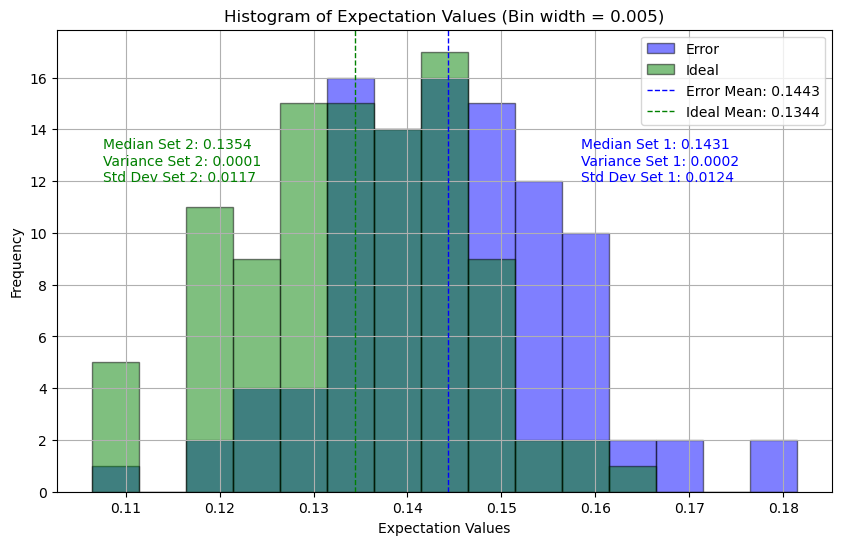

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# 假設已經有 ErrorExpectation 和 IdealExpectation 的數據
# ErrorExpectation 和 IdealExpectation 是一維 numpy array

# 設定參數
bin_width = 0.005  # bin 的寬度
bins = np.arange(min(min(ErrorExpectation), min(IdealExpectation)),
                 max(max(ErrorExpectation), max(IdealExpectation)) + bin_width, bin_width)

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(ErrorExpectation, bins=bins, alpha=0.5, label='Error', color='blue', edgecolor='black')
plt.hist(IdealExpectation, bins=bins, alpha=0.5, label='Ideal', color='green', edgecolor='black')

# 計算統計數據
mean_set1 = np.mean(ErrorExpectation)
median_set1 = np.median(ErrorExpectation)
std_dev_set1 = np.std(ErrorExpectation)

mean_set2 = np.mean(IdealExpectation)
median_set2 = np.median(IdealExpectation)
std_dev_set2 = np.std(IdealExpectation)

# 添加統計線
plt.axvline(mean_set1, color='blue', linestyle='dashed', linewidth=1, label=f'Error Mean: {mean_set1:.4f}')
plt.axvline(mean_set2, color='green', linestyle='dashed', linewidth=1, label=f'Ideal Mean: {mean_set2:.4f}')

# 添加標籤、圖例和標題
plt.xlabel('Expectation Values')
plt.ylabel('Frequency')
plt.title('Histogram of Expectation Values (Bin width = 0.005)')
plt.legend(loc='upper right', fontsize=10)

# 添加統計數據注解
plt.text(max(ErrorExpectation)-0.02, 12,  # 調整位置以適合數據範圍
         f'Median Set 1: {median_set1:.4f}\nVariance Set 1: {np.var(ErrorExpectation):.4f}\nStd Dev Set 1: {std_dev_set1:.4f}',
         color='blue', fontsize=10)

plt.text(min(IdealExpectation), 12,
         f'Median Set 2: {median_set2:.4f}\nVariance Set 2: {np.var(IdealExpectation):.4f}\nStd Dev Set 2: {std_dev_set2:.4f}',
         color='green', fontsize=10)

# 顯示網格
plt.grid(True)
plt.show()